## EJEMPLO DE PROCESO ITERATIVO

##Librerias

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from tabulate import tabulate
from itertools import product

# Modelos de Machine Learning
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import xgboost as xgb

# Preprocesamiento
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Model Selection y Validación
from sklearn.model_selection import (
    train_test_split, cross_val_score, learning_curve, validation_curve
)

# Métricas
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, precision_score, recall_score, f1_score
)


##LLAMAR A AZURE Y DESCARGAR FICHERO

Usar para el caso practico  en local exportando a CSV

In [20]:
import pyodbc
import pandas as pd

# Configuración de conexión a Azure SQL con AAD
SERVER = 'uaxmathfis.database.windows.net'
DATABASE = 'usecases'
DRIVER = '{ODBC Driver 18 for SQL Server}'

# Usar autenticación interactiva de Azure Active Directory (abre una ventana de login)
conn_str = f"DRIVER={DRIVER};SERVER={SERVER};DATABASE={DATABASE};Authentication=ActiveDirectoryInteractive"

try:
    conn = pyodbc.connect(conn_str)
    sql_query = "SELECT * FROM [DATAEX].[IA_PROPENSITY_TRAIN]"
    data = pd.read_sql(sql_query, conn)

    print(data.head())
    print(" Conexión exitosa con Azure SQL usando AAD (interactivo).")

    # Ruta de exportación
    csv_path = r"C:\Users\jvela\OneDrive - Universidad Alfonso X el Sabio\Docencia\IA\CASOS DE USO\propensity\data_export.csv"
    
    # Exportar a CSV
    data.to_csv(csv_path, index=False, encoding='utf-8-sig')
    print(f" Datos exportados exitosamente a: {csv_path}")

except Exception as e:
    print(f" Error de conexión: {e}")

    

C:\Users\jvela\AppData\Local\Temp\ipykernel_35540\3475367924.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(sql_query, conn)


   CODE PRODUCTO TIPO_CARROCERIA COMBUSTIBLE Potencia TRANS        FORMA_PAGO  \
0  CLI1        A           TIPO1      FUEL 1     Baja     M           Contado   
1  CLI2        A           TIPO1      FUEL 1     Baja     M           Contado   
2  CLI3        A           TIPO1      FUEL 1     Baja     M             Otros   
3  CLI4        A           TIPO1      FUEL 1     Baja     M  Financiera Marca   
4  CLI5        A           TIPO1      FUEL 1     Baja     M  Financiera Marca   

  ESTADO_CIVIL GENERO    OcupaciOn  ...  Zona_Renta REV_Garantia  \
0       CASADO      M      Empresa  ...  Medio-Bajo      NO DATA   
1       CASADO      F      Empresa  ...  Medio-Bajo           SI   
2       CASADO      M      Empresa  ...       Medio      NO DATA   
3       CASADO      F      Empresa  ...       Medio           SI   
4       CASADO      F  Funcionario  ...        Alto      NO DATA   

       Averia_grave QUEJA_CAC COSTE_VENTA km_anno Mas_1_coche Revisiones  \
0  Averia muy grave        S

##TRATAMIENTO INFORMACION LABEL ENCODERS

In [17]:
# Dividir los datos en características (X) y etiquetas (y)
X = data.drop(['Mas_1_coche','Tiempo'], axis=1)
y = data['Mas_1_coche']

# Convertir características categóricas a numéricas
label_encoders = {}
for column in X.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    X[column] = label_encoders[column].fit_transform(X[column])

""""LabelEncoder convierte categorías en valores numéricos enteros (0,1,2,...).
 **Útil para variables ordinales (cuando hay un orden lógico entre categorías).
También se usa en y cuando la variable objetivo es categórica."""

# Manejar valores nulos (si existen) después de la conversión
X.fillna(0, inplace=True)

# Eliminar la columna 'Customer ID' si existe
if 'CODE' in data.columns:
    data.drop(['CODE','Tiempo'], axis=1, inplace=True)

# Obtener información del dataframe
print(data.head())
print(data.info())
# Obtener información del dataframe
print(X.info())
# Obtener información del dataframe
print(y.info())

  PRODUCTO TIPO_CARROCERIA COMBUSTIBLE Potencia TRANS        FORMA_PAGO  \
0        A           TIPO1      FUEL 1     Baja     M           Contado   
1        A           TIPO1      FUEL 1     Baja     M           Contado   
2        A           TIPO1      FUEL 1     Baja     M             Otros   
3        A           TIPO1      FUEL 1     Baja     M  Financiera Marca   
4        A           TIPO1      FUEL 1     Baja     M  Financiera Marca   

  ESTADO_CIVIL GENERO    OcupaciOn               PROVINCIA  ... Campanna3  \
0       CASADO      M      Empresa                Asturias  ...        NO   
1       CASADO      F      Empresa                  Toledo  ...        NO   
2       CASADO      M      Empresa                  Lerida  ...        NO   
3       CASADO      F      Empresa                  Madrid  ...        NO   
4       CASADO      F  Funcionario  Santa Cruz de Tenerife  ...        SI   

   Zona_Renta REV_Garantia      Averia_grave QUEJA_CAC COSTE_VENTA km_anno  \
0  Medio

##ONEHOT ENCODER + CREAR TABLA DE ENTRENAMIENTO

In [18]:
# Codificar variables categóricas si es necesario
#categorical_columns = X.select_dtypes(include=['object']).columns
#encoder = OneHotEncoder()
#X_encoded = pd.DataFrame(encoder.fit_transform(X[categorical_columns]).toarray())
#X_encoded.columns = encoder.get_feature_names_out(categorical_columns)
#X = pd.concat([X.drop(columns=categorical_columns), X_encoded], axis=1)
"""OneHotEncoder convierte cada categoría en una columna binaria (0 o 1).
Útil para variables nominales (sin orden entre categorías).
Se recomienda si hay muchas categorías para evitar interpretaciones incorrectas."""""

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convertir y_train a formato numérico
y_train = y_train.astype(int)

# Convertir y_test a formato numérico
y_test = y_test.astype(int)



##ITERACION DEL MODELO

Criterion: gini, Splitter: best, Max Depth: 3, Min Samples Split: 2, Min Samples Leaf: 1
Accuracy: 0.7933677863910422, F1 Score: 0.7979961577662463, Recall: 0.7933677863910422, ROC-AUC: 0.8192628081819413, CV Score: 0.7897457194988002, Train Score: 0.7906716337561102, Overfitting: OK
Criterion: gini, Splitter: best, Max Depth: 3, Min Samples Split: 2, Min Samples Leaf: 2
Accuracy: 0.7933677863910422, F1 Score: 0.7979961577662463, Recall: 0.7933677863910422, ROC-AUC: 0.8192628081819413, CV Score: 0.7897457194988002, Train Score: 0.7906716337561102, Overfitting: OK
Criterion: gini, Splitter: best, Max Depth: 3, Min Samples Split: 2, Min Samples Leaf: 5
Accuracy: 0.7933677863910422, F1 Score: 0.7979961577662463, Recall: 0.7933677863910422, ROC-AUC: 0.8192628081819413, CV Score: 0.7897457194988002, Train Score: 0.7906716337561102, Overfitting: OK
Criterion: gini, Splitter: best, Max Depth: 3, Min Samples Split: 5, Min Samples Leaf: 1
Accuracy: 0.7933677863910422, F1 Score: 0.79799615776624

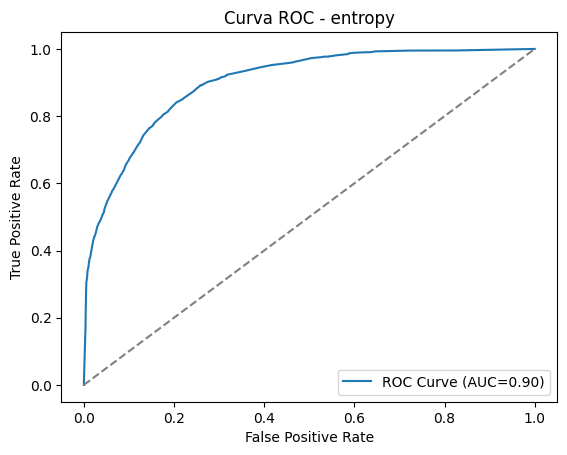

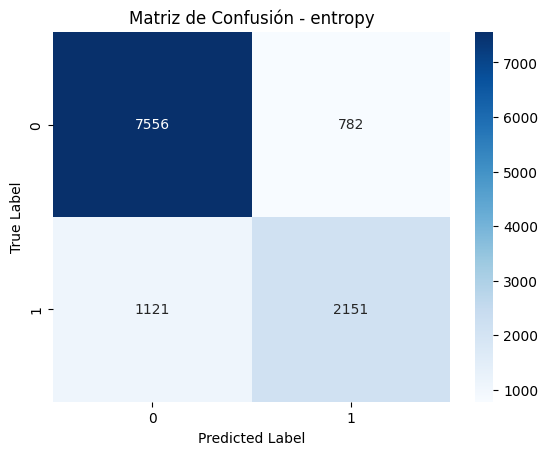

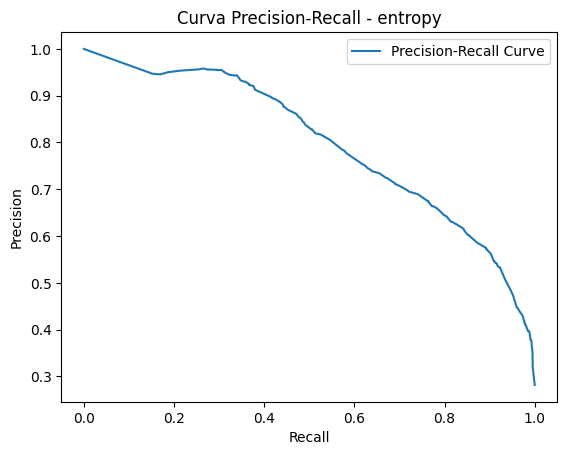


--------------------------------------------------
Modelo Optimizado 134
--------------------------------------------------
Criterion: log_loss, Splitter: best, Max Depth: 10, Min Samples Split: 10, Min Samples Leaf: 2

Classification Report for log_loss - best:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      8338
           1       0.73      0.66      0.69      3272

    accuracy                           0.84     11610
   macro avg       0.80      0.78      0.79     11610
weighted avg       0.83      0.84      0.83     11610


ROC-AUC Score: 0.900270072475795



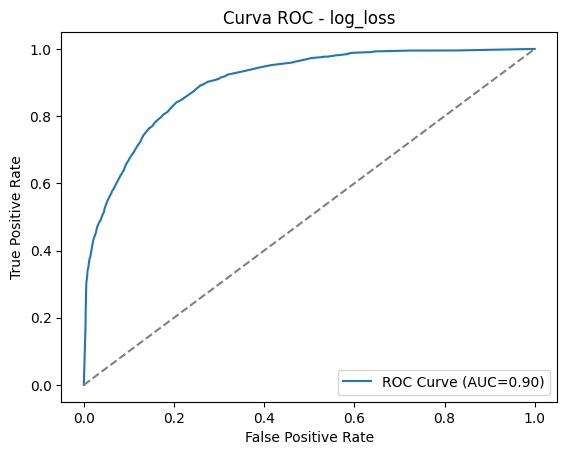

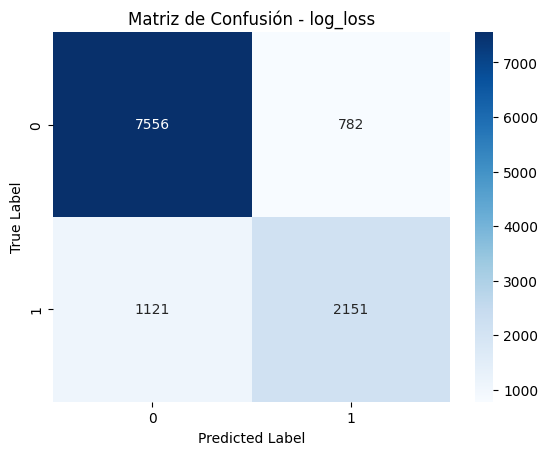

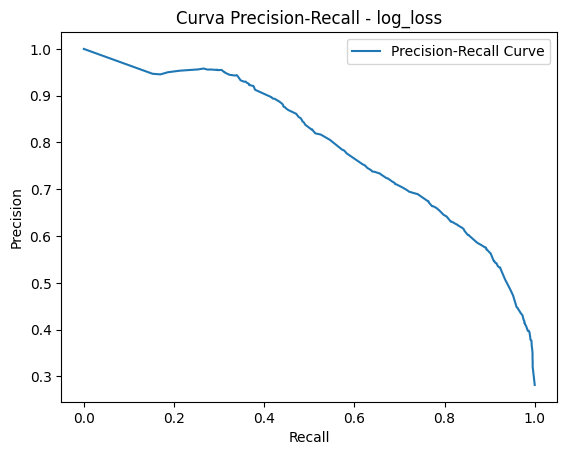


--------------------------------------------------
Modelo Optimizado 79
--------------------------------------------------
Criterion: entropy, Splitter: best, Max Depth: 10, Min Samples Split: 10, Min Samples Leaf: 1

Classification Report for entropy - best:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      8338
           1       0.73      0.66      0.69      3272

    accuracy                           0.84     11610
   macro avg       0.80      0.78      0.79     11610
weighted avg       0.83      0.84      0.83     11610


ROC-AUC Score: 0.900270072475795



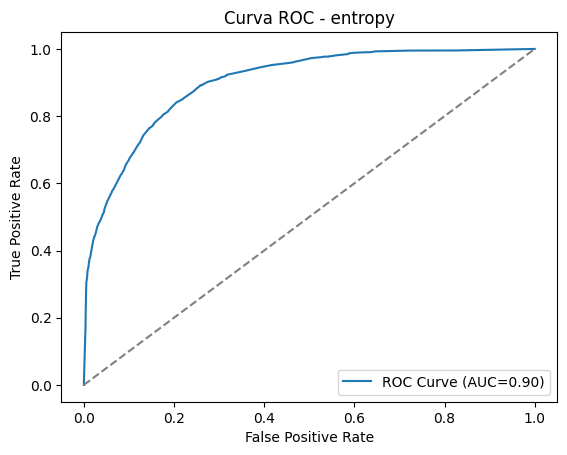

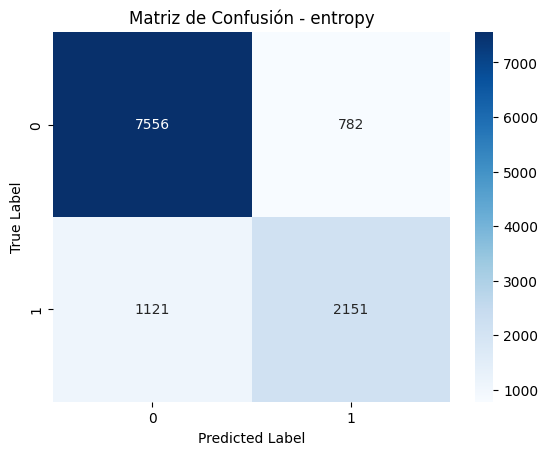

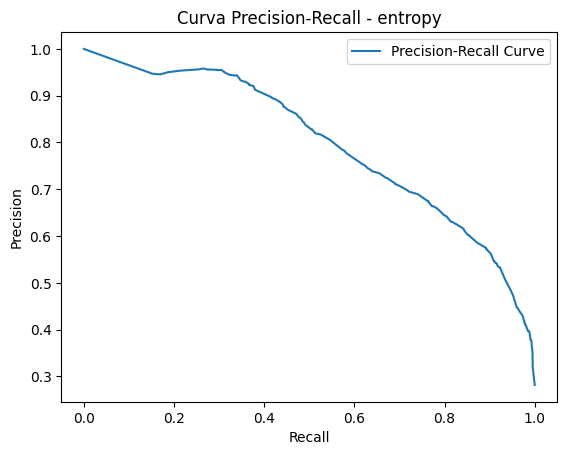

,criterion,splitter,max_depth,min_samples_split,min_samples_leaf,accuracy,f1_score,recall,roc_auc,cv_score,train_score,overfitting
79,entropy,best,10,10,2,0.851938,0.851807,0.851938,0.923772,0.847499,0.866233,OK
133,log_loss,best,10,10,2,0.851938,0.851807,0.851938,0.923772,0.847499,0.866233,OK
78,entropy,best,10,10,1,0.851852,0.851714,0.851852,0.922534,0.847671,0.866492,OK


In [19]:


# Definir hiperparámetros a iterar
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': [ 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}
"""splitter="best" (por defecto)
Encuentra el mejor punto de división en cada nodo, basado en la métrica de evaluación (criterion).
Tiende a crear árboles más profundos, porque optimiza cada división localmente.
Útil para conjuntos de datos pequeños.
splitter="random". En lugar de buscar el mejor punto de división, elige un punto de división de manera aleatoria 
entre los mejores candidatos.
Puede generar árboles más pequeños y con menos sobreajuste.
Útil para conjuntos de datos grandes o cuando se usa en bagging/random forests.
----------------------------------------------------
Define el número mínimo de muestras necesarias para dividir un nodo.
Si min_samples_split=2, cualquier nodo con 2 o más muestras puede dividirse.
Si min_samples_split=10, un nodo necesita al menos 10 muestras para dividirse.
Valores bajos (2-5) → Árbol más profundo y detallado, mayor riesgo de sobreajuste.
Valores altos (10-20) → Árbol más generalizado, menor sobreajuste.
------------------------------------------------------
Define el número mínimo de muestras necesarias en una hoja (nodo final).
Si min_samples_leaf=1, el árbol puede crear nodos con solo 1 muestra.
Si min_samples_leaf=5, cada hoja debe tener al menos 5 muestras.
Valores bajos (1-3) → Árbol más detallado, mayor riesgo de sobreajuste.
Valores altos (5-10) → Árbol más pequeño y estable, menos sobreajuste.
"""


# Almacenar resultados
results = []

# Iterar sobre todas las combinaciones de hiperparámetros
for params in product(*param_grid.values()):
    criterion, splitter, max_depth, min_samples_split, min_samples_leaf = params
    
    """Este código es un bucle for que recorre todas las combinaciones posibles de hiperparámetros usando 
    itertools.product. Es una técnica común para realizar búsqueda exhaustiva (grid search) en modelos de machine 
    learning.  Genera todas las combinaciones de valores de param_grid.
    param_grid.values() obtiene las listas de valores de cada hiperparámetro.
    *param_grid.values() descomprime los valores dentro de product().
    product(*param_grid.values()) devuelve todas las combinaciones posibles de hiperparámetros."""   

    # Construir el modelo con los hiperparámetros actuales
    model = DecisionTreeClassifier(
        criterion=criterion, 
        splitter=splitter, 
        max_depth=max_depth, 
        min_samples_split=min_samples_split, 
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    # Entrenar el modelo
    model.fit(X_train, y_train)
    
    # Predecir en el conjunto de prueba
    y_pred = model.predict(X_test)
    
    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    # Calcular ROC-AUC si hay más de una clase
    if len(np.unique(y_test)) > 1:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
    else:
        roc_auc = None
    
    # Validación cruzada
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    mean_cv_score = np.mean(cv_scores)
    
    # Calcular Train Score
    train_score = model.score(X_train, y_train)
    
    # Determinar si hay sobreajuste
    if train_score > 1.5 * mean_cv_score:
     overfitting_warning = "SEVERE OVERFITTING"
    elif train_score > 1.2 * mean_cv_score:
     overfitting_warning = "DANGER"
    elif train_score > 1.1 * mean_cv_score:
     overfitting_warning = "MILD OVERFITTING"
    else:
     overfitting_warning = "OK"
    """Esta línea de código verifica si hay sobreajuste (overfitting) comparando el rendimiento en entrenamiento 
    (train_score) con el rendimiento promedio en validación (mean_cv_score). Si el modelo tiene un rendimiento 
    muy alto en entrenamiento, pero mucho menor en validación, significa que está memorizando los datos 
    de entrenamiento en lugar de generalizar bien. Se usa un umbral del 20% (1.2 * mean_cv_score) para marcar 
    la diferencia como sospechosa."""
    
    # Guardar los resultados
    results.append({
        'criterion': criterion,
        'splitter': splitter,
        'max_depth': int(max_depth) if pd.notna(max_depth) else None,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'accuracy': accuracy,
        'f1_score': f1,
        'recall': recall,
        'roc_auc': roc_auc,
        'cv_score': mean_cv_score,
        'train_score': train_score,
        'overfitting': overfitting_warning
    })

# Imprimir resultados parciales
    print(f"Criterion: {criterion}, Splitter: {splitter}, Max Depth: {max_depth}, Min Samples Split: {min_samples_split}, Min Samples Leaf: {min_samples_leaf}")
    print(f"Accuracy: {accuracy}, F1 Score: {f1}, Recall: {recall}, ROC-AUC: {roc_auc}, CV Score: {mean_cv_score}, Train Score: {train_score}, Overfitting: {overfitting_warning}")

# Convertir resultados a DataFrame y seleccionar los 3 mejores modelos
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by=['f1_score', 'accuracy'], ascending=False)

# Seleccionar el mejor modelo sin sobreajuste y optimizando F1 Score
best_models = results_df[results_df['overfitting'] == 'OK'].head(3)

for index, row in best_models.iterrows():
    print('\n' + '-' * 50)
    print(f'Modelo Optimizado {index + 1}')
    print('-' * 50)
    print(f'Criterion: {row["criterion"]}, Splitter: {row["splitter"]}, Max Depth: {row["max_depth"]}, Min Samples Split: {row["min_samples_split"]}, Min Samples Leaf: {row["min_samples_leaf"]}')
    print(f'\nClassification Report for {row["criterion"]} - {row["splitter"]}:')
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    if len(np.unique(y_test)) > 1:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        print(f'\nROC-AUC Score: {roc_auc}\n')
        
        # Curva ROC
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.figure()
        plt.plot(fpr, tpr, label=f"ROC Curve (AUC={roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Curva ROC - {row["criterion"]}')
        plt.legend()
        plt.show()
        
        # Matriz de confusión
        plt.figure()
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Matriz de Confusión - {row["criterion"]}')
        plt.show()
        
        # Curva Precision-Recall
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        plt.figure()
        plt.plot(recall, precision, label='Precision-Recall Curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Curva Precision-Recall - {row["criterion"]}')
        plt.legend()
        plt.show()

# Mostrar los mejores modelos
from IPython.display import display
display(best_models)
